In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax
import os
jax.devices()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[CpuDevice(id=0)]

In [4]:
import pandas as pd
from src import ComputationalHypergraphDiscovery as CHD
#from ComputationalHypergraphDiscovery.Modes import LinearMode, QuadraticMode, GaussianMode
import numpy as onp
import matplotlib.pyplot as plt
import networkx as nx
import pickle
from tqdm import tqdm
import jax.numpy as np

In [5]:
additional=10

df=pd.read_csv('./BCR.csv')
df=df[df.columns[df.std(axis=0)!=0]]
relabel={n:n.replace('\\','/') for n in df.columns}
df.columns=[n.replace('\\','/') for n in df.columns]
cut=2400
df_train=df[:cut]
df_test=df[cut:]
df

S0            S1             S2            S3            S4  \
0          0.000002  7.304403e+05  585317.631604  3.615158e+06  6.195899e+06   
1          0.000002  8.655895e+05  710888.179756  3.574970e+06  6.491118e+06   
2     119649.797101  1.153809e+05  115380.207169  1.112686e+05  1.199996e+05   
3     119700.023569  1.154077e+05  115407.275307  1.112727e+05  1.200000e+05   
4      29981.379311  2.969648e+04   29696.495350  2.941458e+04  3.000000e+04   
...             ...           ...            ...           ...           ...   
5000       0.000002  1.115007e+06  974531.302015  3.526420e+06  7.075370e+06   
5001  297148.127742  2.735912e+05  273583.446419  2.519036e+05  2.999944e+05   
5002       0.000006  1.774727e+03    1420.282767  3.076068e+06  3.791961e+06   
5003       0.000006  1.772895e+03    1418.532250  3.074676e+06  3.790500e+06   
5004   29981.139702  2.969627e+04   29696.305442  2.941445e+04  3.000000e+04   

                 S5            S6            S7             S8            S9  \
0     238895.045577  8.643072e-10  15248.430999  166357.589035  6.986633e-10   
1     242966.103845  1.121930e-09  15863.426978  175871.708328  9.284568e-10   
2     119999.999716  1.380535e+02      1.361351       2.606950  1.380527e+02   
3     119999.999968  1.381435e+02      1.247712       1.960094  1.381430e+02   
4      30000.000000  8.903415e+00      0.141142       0.175124  8.903421e+00   
...             ...           ...           ...            ...           ...   
5000  341835.359312  1.769014e-09  16984.587413  161878.040296  1.554103e-09   
5001  299999.936688  8.129941e+02      4.703674      14.391908  8.129719e+02   
5002  238032.895425  9.719790e-12   5020.205605    8163.711747  8.458764e-12   
5003  238033.025601  9.717387e-12   5016.628520    8156.249045  8.455209e-12   
5004   30000.000000  8.903281e+00      0.141296       0.175598  8.903293e+00   

      ...  $/partial_t S1112$  $/partial_t S1113$  $/partial_t S1114$  \
0     ...        3.475410e-03        1.443360e-07        3.354071e-05   
1     ...        1.699553e-03        9.848641e-08        1.868933e-05   
2     ...        7.076956e-12        2.232804e-25        8.339580e-18   
3     ...        3.351184e-12        1.419783e-25        2.645328e-19   
4     ...        2.161153e-14        7.088757e-29        7.795995e-22   
...   ...                 ...                 ...                 ...   
5000  ...        2.343143e-04        2.910494e-08        2.970329e-06   
5001  ...        1.690567e-10        3.790267e-23        1.342285e-15   
5002  ...       -4.378077e-03        8.244811e-07       -2.500028e-04   
5003  ...       -4.356279e-03        8.249133e-07       -2.500649e-04   
5004  ...        1.604687e-14        6.186747e-29        6.150598e-22   

      $/partial_t S1115$  $/partial_t S1116$  $/partial_t S1117$  \
0           2.561977e-04        7.731132e+01        2.031811e-02   
1           1.695635e-04        9.745335e+01        1.961951e-02   
2           1.121754e-16        1.250482e-06        2.413633e-13   
3           4.152657e-17        1.089697e-05        1.243332e-13   
4           1.058060e-19        9.732877e-09        2.788445e-16   
...                  ...                 ...                 ...   
5000        5.085564e-05        1.635863e+02        1.075838e-02   
5001        7.824249e-15        4.464824e-05        1.354047e-11   
5002       -5.748210e-04       -2.049486e+01       -1.760463e-03   
5003       -5.732107e-04       -2.039048e+01       -1.746116e-03   
5004        7.836599e-20        4.484323e-10        1.428160e-16   

      $/partial_t S1118$  $/partial_t S1119$  $/partial_t S1120$  \
0           1.493338e+02        3.616471e+02        4.624753e-03   
1           1.264184e+02        3.378304e+02        5.203614e-03   
2           3.161855e-05        7.004705e-05        2.528237e-15   
3           3.787004e-06        1.660261e-05        3.995675e-14   
4           1.478142e-07        3.238233e-07        4.869930e

In [6]:
possible_edges=nx.DiGraph()
edges=[]
for f_node in tqdm(df.columns):
    if 'partial' in f_node:
        continue
    for nf_node in df.columns:
        if 'partial' in nf_node:
            edges.append((f_node,nf_node))
            edges.append((nf_node,f_node))
possible_edges.add_edges_from(edges)

  0%|          | 0/2244 [00:00<?, ?it/s]

100%|██████████| 2244/2244 [00:00<00:00, 2994.00it/s]


In [7]:
graph_discovery=CHD.GraphDiscovery.from_dataframe(df_train,normalize=True,possible_edges=possible_edges,kernels=[CHD.Modes.QuadraticMode(memory_efficient_required=True)],gamma_min=1e-9)

Converting possible edges to dense adjacency matrix
making a function that is non-interpolatory


In [8]:
import glob

graphs = [pickle.load(open(path, "rb")) for path in tqdm(glob.glob('./results_all_original_BCR/*.pkl'))]
graphs = [nx.relabel_nodes(graph, relabel) for graph in graphs]

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:23<00:00,  1.92s/it]


In [9]:

for g in graphs:
    graph_discovery.G=nx.compose(graph_discovery.G,g)

In [10]:
treated=[]
indices=nx.get_node_attributes(graph_discovery.G, "kernel_index")
for node in graph_discovery.G.nodes:
    try:
        indices[node]
        treated.append(node)
    except:
        pass

treated

    


['$/partial_t S0$',
 '$/partial_t S1$',
 '$/partial_t S2$',
 '$/partial_t S3$',
 '$/partial_t S4$',
 '$/partial_t S5$',
 '$/partial_t S6$',
 '$/partial_t S7$',
 '$/partial_t S8$',
 '$/partial_t S9$',
 '$/partial_t S10$',
 '$/partial_t S11$',
 '$/partial_t S12$',
 '$/partial_t S13$',
 '$/partial_t S14$',
 '$/partial_t S15$',
 '$/partial_t S16$',
 '$/partial_t S17$',
 '$/partial_t S18$',
 '$/partial_t S19$',
 '$/partial_t S20$',
 '$/partial_t S21$',
 '$/partial_t S22$',
 '$/partial_t S23$',
 '$/partial_t S24$',
 '$/partial_t S25$',
 '$/partial_t S26$',
 '$/partial_t S27$',
 '$/partial_t S28$',
 '$/partial_t S29$',
 '$/partial_t S30$',
 '$/partial_t S31$',
 '$/partial_t S32$',
 '$/partial_t S33$',
 '$/partial_t S34$',
 '$/partial_t S35$',
 '$/partial_t S36$',
 '$/partial_t S37$',
 '$/partial_t S38$',
 '$/partial_t S39$',
 '$/partial_t S40$',
 '$/partial_t S41$',
 '$/partial_t S42$',
 '$/partial_t S43$',
 '$/partial_t S44$',
 '$/partial_t S45$',
 '$/partial_t S46$',
 '$/partial_t S47$',
 '

In [11]:
active_mode_dic = nx.get_node_attributes(graph_discovery.G, "active_modes")
for node,active_mode in active_mode_dic.items():
    missing=graph_discovery.X.shape[1]-active_mode.shape[0]
    graph_discovery.G.nodes[node]["active_modes"] =jax.numpy.pad(active_mode,(0,missing),'constant',constant_values=(0,0))

In [12]:
k_dic = nx.get_node_attributes(graph_discovery.G, "kernel_index")
is_zero=np.array([k_dic.get(name, -1) for name in treated])==-1
is_zero

Array([False, False, False, ..., False, False, False], dtype=bool)

In [13]:
is_zero_mode=np.array([np.all(graph_discovery.G.nodes[name].get("active_modes",np.array([0]))==0) for name in treated])
is_zero_mode

Array([False, False, False, ..., False, False, False], dtype=bool)

In [14]:
is_zero=np.logical_or(is_zero,is_zero_mode)
is_zero

Array([False, False, False, ..., False, False, False], dtype=bool)

In [15]:
treated_and_zero=[treated[i] for i in range(len(treated)) if is_zero[i]]
to_treat=list(df.columns)[1122:]
batch_size=100
to_analyze_batches = [
    list(to_treat[i : i + batch_size])
    for i in range(0, len(to_treat), batch_size)
]
'''to_analyze_batches[-1] = to_analyze_batches[-1][
    : len(to_analyze_batches) % batch_size
]'''
df_batches = pd.DataFrame(to_analyze_batches)
df_batches.columns = [f"target {i}" for i in range(1, batch_size + 1)]
df_batches
#df_batches.to_csv("batches.csv", index=False)
df_batches

target 1            target 2            target 3  \
0      $/partial_t S0$     $/partial_t S1$     $/partial_t S2$   
1    $/partial_t S100$   $/partial_t S101$   $/partial_t S102$   
2    $/partial_t S200$   $/partial_t S201$   $/partial_t S202$   
3    $/partial_t S300$   $/partial_t S301$   $/partial_t S302$   
4    $/partial_t S400$   $/partial_t S401$   $/partial_t S402$   
5    $/partial_t S500$   $/partial_t S501$   $/partial_t S502$   
6    $/partial_t S600$   $/partial_t S601$   $/partial_t S602$   
7    $/partial_t S700$   $/partial_t S701$   $/partial_t S702$   
8    $/partial_t S800$   $/partial_t S801$   $/partial_t S802$   
9    $/partial_t S900$   $/partial_t S901$   $/partial_t S902$   
10  $/partial_t S1000$  $/partial_t S1001$  $/partial_t S1002$   
11  $/partial_t S1100$  $/partial_t S1101$  $/partial_t S1102$   

              target 4            target 5            target 6  \
0      $/partial_t S3$     $/partial_t S4$     $/partial_t S5$   
1    $/partial_t S103$   $/partial_t S104$   $/partial_t S105$   
2    $/partial_t S203$   $/partial_t S204$   $/partial_t S205$   
3    $/partial_t S303$   $/partial_t S304$   $/partial_t S305$   
4    $/partial_t S403$   $/partial_t S404$   $/partial_t S405$   
5    $/partial_t S503$   $/partial_t S504$   $/partial_t S505$   
6    $/partial_t S603$   $/partial_t S604$   $/partial_t S605$   
7    $/partial_t S703$   $/partial_t S704$   $/partial_t S705$   
8    $/partial_t S803$   $/partial_t S804$   $/partial_t S805$   
9    $/partial_t S903$   $/partial_t S904$   $/partial_t S905$   
10  $/partial_t S1003$  $/partial_t S1004$  $/partial_t S1005$   
11  $/partial_t S1103$  $/partial_t S1104$  $/partial_t S1105$   

              target 7            target 8            target 9  \
0      $/partial_t S6$     $/partial_t S7$     $/partial_t S8$   
1    $/partial_t S106$   $/partial_t S107$   $/partial_t S108$   
2    $/partial_t S206$   $/partial_t S207$   $/partial_t S208$   
3    $/partial_t S306$   $/partial_t S307$   $/partial_t S308$   
4    $/partial_t S406$   $/partial_t S407$   $/partial_t S408$   
5    $/partial_t S506$   $/partial_t S507$   $/partial_t S508$   
6    $/partial_t S606$   $/partial_t S607$   $/partial_t S608$   
7    $/partial_t S706$   $/partial_t S707$   $/partial_t S708$   
8    $/partial_t S806$   $/partial_t S807$   $/partial_t S808$   
9    $/partial_t S906$   $/partial_t S907$   $/partial_t S908$   
10  $/partial_t S1006$  $/partial_t S1007$  $/partial_t S1008$   
11  $/partial_t S1106$  $/partial_t S1107$  $/partial_t S1108$   

             target 10  ...           target 91           target 92  \
0      $/partial_t S9$  ...    $/partial_t S90$    $/partial_t S91$   
1    $/partial_t S109$  ...   $/partial_t S190$   $/partial_t S191$   
2    $/partial_t S209$  ...   $/partial_t S290$   $/partial_t S291$   
3    $/partial_t S309$  ...   $/partial_t S390$   $/partial_t S391$   
4    $/partial_t S409$  ...   $/partial_t S490$   $/partial_t S491$   
5    $/partial_t S509$  ...   $/partial_t S590$   $/partial_t S591$   
6    $/partial_t S609$  ...   $/partial_t S690$   $/partial_t S691$   
7    $/partial_t S709$  ...   $/partial_t S790$   $/partial_t S791$   
8    $/partial_t S809$  ...   $/partial_t S890$   $/partial_t S891$   
9    $/partial_t S909$  ...   $/partial_t S990$   $/partial_t S991$   
10  $/partial_t S1009$  ...  $/partial_t S1090$  $/partial_t S1091$   
11  $/partial_t S1109$  ...                None                None   

             target 93           target 94           target 95  \
0     $/partial_t S92$    $/partial_t S93$    $/partial_t S94$   
1    $/partial_t S192$   $/partial_t S193$   $/partial_t S194$   
2    $/partial_t S292$   $/partial_t S293$   $/partial_t S294$   
3    $/partial_t S392$   $/partial_t S393$   $/partial_t S394$   
4    $/partial_t S492$   $/partial_t S493$   $/partial_t S494$   
5    $/partial_t S592$   $/partial_t S593$   $/partial_t S594$   
6    $/partial_t S692$   $/partial_t S693$   $/part

In [16]:
X=np.array(graph_discovery.X)

In [17]:
Q=CHD.Modes.QuadraticMode(memory_efficient_required=True)
Q.setup(X)

In [18]:
get_activations=CHD.helper_functions.make_activation_function(Q,True)

In [19]:
(X[:,0][:,None]*X[:,0][None,:])

Array([[ 0.11479208,  0.11479208,  0.01007628, ...,  0.11479208,
        -0.14424047, -0.14375719],
       [ 0.11479208,  0.11479208,  0.01007628, ...,  0.11479208,
        -0.14424047, -0.14375719],
       [ 0.01007628,  0.01007628,  0.00088448, ...,  0.01007628,
        -0.01266122, -0.0126188 ],
       ...,
       [ 0.11479208,  0.11479208,  0.01007628, ...,  0.11479208,
        -0.14424047, -0.14375719],
       [-0.14424047, -0.14424047, -0.01266122, ..., -0.14424047,
         0.18124345,  0.18063619],
       [-0.14375719, -0.14375719, -0.0126188 , ..., -0.14375719,
         0.18063619,  0.18003096]], dtype=float64)

In [20]:

which_dim=np.ones(X.shape[1])
which_dim_only=np.zeros(X.shape[1])
which_dim_only=which_dim_only.at[0].set(1.0)
indiv=Q.individual_influence(X,X,which_dim,which_dim_only)
indiv

[[ 0.11479208  0.11479208  0.01007628 ...  0.11479208 -0.14424047
  -0.14375719]
 [ 0.11479208  0.11479208  0.01007628 ...  0.11479208 -0.14424047
  -0.14375719]
 [ 0.01007628  0.01007628  0.00088448 ...  0.01007628 -0.01266122
  -0.0126188 ]
 ...
 [ 0.11479208  0.11479208  0.01007628 ...  0.11479208 -0.14424047
  -0.14375719]
 [-0.14424047 -0.14424047 -0.01266122 ... -0.14424047  0.18124345
   0.18063619]
 [-0.14375719 -0.14375719 -0.0126188  ... -0.14375719  0.18063619
   0.18003096]]
[[5114.4826475  4696.20261295 -465.92667667 ...  -15.34892225
  -464.51538928 -464.94579635]
 [4696.20261295 4546.43901836 -365.46621424 ... -368.57348184
  -363.49234881 -363.93788066]
 [-465.92667667 -365.46621424  188.87586101 ... -932.71221254
   187.03800181  186.5890138 ]
 ...
 [ -15.34892225 -368.57348184 -932.71221254 ... 7618.54726321
  -934.5102678  -934.95808601]
 [-464.51538928 -363.49234881  187.03800181 ... -934.5102678
   198.89934665  202.54582487]
 [-464.94579635 -363.93788066  186.5890

Array([[ 1.17444696e+03,  1.07841649e+03, -9.36936487e+00, ...,
        -3.28110802e+00,  1.33736157e+02,  1.33411751e+02],
       [ 1.07841649e+03,  1.04403314e+03, -7.34482859e+00, ...,
        -8.43758712e+01,  1.04592936e+02,  1.04370523e+02],
       [-9.36936487e+00, -7.34482859e+00,  3.35884246e-01, ...,
        -1.87762921e+01, -4.76142112e+00, -4.73413706e+00],
       ...,
       [-3.28110802e+00, -8.43758712e+01, -1.87762921e+01, ...,
         1.74934052e+03,  2.69320718e+02,  2.68547039e+02],
       [ 1.33736157e+02,  1.04592936e+02, -4.76142112e+00, ...,
         2.69320718e+02,  7.24937426e+01,  7.35681132e+01],
       [ 1.33411751e+02,  1.04370523e+02, -4.73413706e+00, ...,
         2.68547039e+02,  7.35681132e+01,  7.51325535e+01]],      dtype=float64)

In [21]:
vec_rest=X[:,1:]
indiv2=(1+X[:,0][:,None]*X[:,0][None,:])**2-1+2*X[:,0][:,None]*X[:,0][None,:]*np.dot(vec_rest,vec_rest.T)
indiv2

Array([[ 1.17444696e+03,  1.07841649e+03, -9.36936487e+00, ...,
        -3.28110802e+00,  1.33736157e+02,  1.33411751e+02],
       [ 1.07841649e+03,  1.04403314e+03, -7.34482859e+00, ...,
        -8.43758712e+01,  1.04592936e+02,  1.04370523e+02],
       [-9.36936487e+00, -7.34482859e+00,  3.35884246e-01, ...,
        -1.87762921e+01, -4.76142112e+00, -4.73413706e+00],
       ...,
       [-3.28110802e+00, -8.43758712e+01, -1.87762921e+01, ...,
         1.74934052e+03,  2.69320718e+02,  2.68547039e+02],
       [ 1.33736157e+02,  1.04592936e+02, -4.76142112e+00, ...,
         2.69320718e+02,  7.24937426e+01,  7.35681132e+01],
       [ 1.33411751e+02,  1.04370523e+02, -4.73413706e+00, ...,
         2.68547039e+02,  7.35681132e+01,  7.51325535e+01]],      dtype=float64)

In [22]:
treated_and_non_zero=[t for t,z in zip(treated,is_zero) if not z]

In [23]:
pred = graph_discovery.predict(treated_and_non_zero,df_test.values)

In [24]:
truth=df_test[treated_and_non_zero].values
truth.shape

(2605, 1122)

In [25]:
std=onp.std(truth,axis=0)

In [26]:
pred.shape

(2605, 1122)

In [116]:
errors= jax.numpy.quantile((truth-pred)**2,0.99,axis=0)/std**2

Array(0.00015306, dtype=float64)

In [28]:
worst_res = graph_discovery.G.nodes[treated_and_non_zero[np.argmax(errors)]]
worst_res

{'active_modes': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
 'kernel_index': 0,
 'type': 'quadratic',
 'gamma': 7.1937733780045116e-06,
 'coeff': Array([-18012.18352583,   6821.62027694,   -414.50261951, ...,
        -11927.50364753,   -265.56708568,   -264.50355834], dtype=float64)}

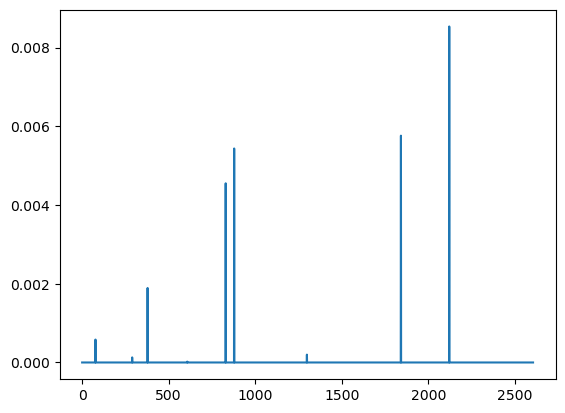

In [29]:
errors_per_sample= jax.numpy.median((truth-pred)**2/std[None,:]**2,axis=1)
plt.plot(errors_per_sample[errors_per_sample<1000])

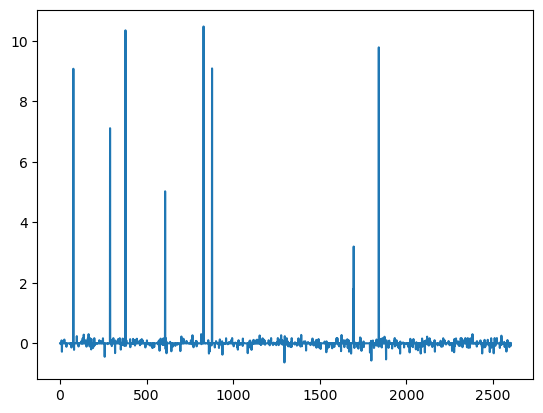

In [30]:
plt.plot((truth-pred)[:,np.argmax(errors)]/std[np.argmax(errors)])

In [31]:
treated_and_non_zero

['$/partial_t S0$',
 '$/partial_t S1$',
 '$/partial_t S2$',
 '$/partial_t S3$',
 '$/partial_t S4$',
 '$/partial_t S5$',
 '$/partial_t S6$',
 '$/partial_t S7$',
 '$/partial_t S8$',
 '$/partial_t S9$',
 '$/partial_t S10$',
 '$/partial_t S11$',
 '$/partial_t S12$',
 '$/partial_t S13$',
 '$/partial_t S14$',
 '$/partial_t S15$',
 '$/partial_t S16$',
 '$/partial_t S17$',
 '$/partial_t S18$',
 '$/partial_t S19$',
 '$/partial_t S20$',
 '$/partial_t S21$',
 '$/partial_t S22$',
 '$/partial_t S23$',
 '$/partial_t S24$',
 '$/partial_t S25$',
 '$/partial_t S26$',
 '$/partial_t S27$',
 '$/partial_t S28$',
 '$/partial_t S29$',
 '$/partial_t S30$',
 '$/partial_t S31$',
 '$/partial_t S32$',
 '$/partial_t S33$',
 '$/partial_t S34$',
 '$/partial_t S35$',
 '$/partial_t S36$',
 '$/partial_t S37$',
 '$/partial_t S38$',
 '$/partial_t S39$',
 '$/partial_t S40$',
 '$/partial_t S41$',
 '$/partial_t S42$',
 '$/partial_t S43$',
 '$/partial_t S44$',
 '$/partial_t S45$',
 '$/partial_t S46$',
 '$/partial_t S47$',
 '

In [32]:
np.sum(graph_discovery.G.nodes[treated_and_non_zero[1]]['active_modes'])

Array(218., dtype=float64)

In [33]:
errors[::10]

Array([8.92356014e-15, 3.85283456e-10, 1.30349104e-12, 4.10038184e-15,
       5.56344679e-16, 1.58497086e-17, 6.61370935e-14, 4.67881103e-14,
       3.04767131e-06, 7.51576723e-13, 7.50563281e-13, 2.20274329e-12,
       4.57020300e-09, 1.97221611e-12, 8.12876089e-08, 1.49831585e-11,
       1.21230743e-12, 1.15239649e-13, 3.36712087e-06, 4.75942896e-11,
       3.24495195e-11, 6.40644573e-14, 3.84146764e-04, 2.27964946e-11,
       1.18159081e-11, 3.45808512e-08, 9.53208655e-08, 2.72710721e-10,
       8.12312637e-09, 2.12366933e-07, 5.28542560e-08, 4.37691422e-07,
       6.34443834e-04, 3.48958478e-11, 4.64584215e-09, 4.39858275e-11,
       1.41624714e-13, 3.46545795e-08, 2.27735748e-08, 1.21864790e-12,
       2.61473735e-14, 5.97440657e-14, 1.26609817e-06, 2.47408035e-09,
       1.78379108e-15, 7.71633261e-15, 4.06172332e-14, 1.41212689e-06,
       1.74267442e-05, 2.12929946e-13, 1.02288440e-05, 1.64849753e-10,
       5.90992778e-08, 4.40490466e-08, 2.35880161e-12, 6.58329111e-09,
      

In [34]:
np.mean(np.log(errors))

Array(-20.23169215, dtype=float64)

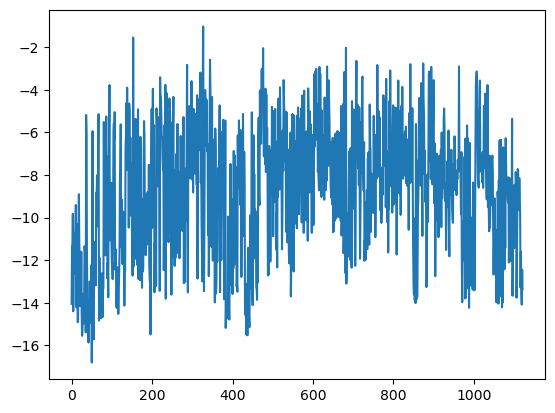

In [35]:
plt.plot(jax.numpy.log10(errors))

In [36]:
errors.shape

(1122,)

In [37]:
true_graph=pickle.load(open('./BCR.pkl','rb'))
true_graph=nx.relabel_nodes(true_graph, relabel)

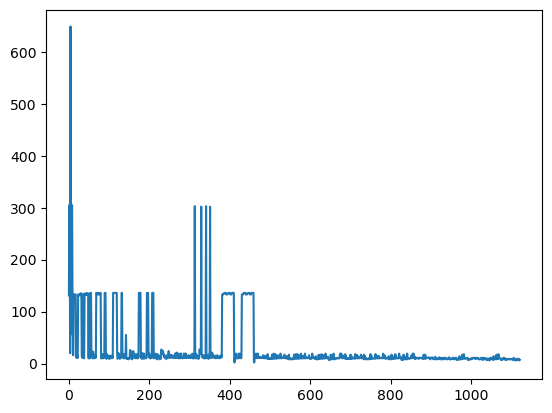

In [38]:
ancestors=np.array([len(nx.ancestors(true_graph,node)) for node in treated_and_non_zero])
plt.plot(ancestors)

In [39]:
#solve 2400=n(n+3)/2
n=int((onp.sqrt(1+8*2400)-3)/2)
n

67

In [40]:
n*(n+3)/2

2345.0

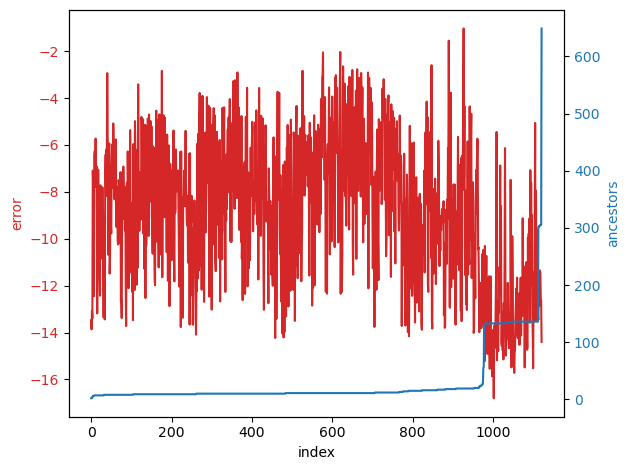

In [41]:
#plot two plots with different y axis
fig, ax1 = plt.subplots()
indexes=np.argsort(ancestors)

color = 'tab:red'
ax1.set_xlabel('index')
ax1.set_ylabel('error', color=color)
ax1.plot(np.log10(errors)[indexes], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('ancestors', color=color)  # we already handled the x-label with ax1
ax2.plot((ancestors)[indexes], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [42]:
true_graph.nodes

NodeView(('S0', '$/partial_t S0$', 'S1', '$/partial_t S1$', 'S2', '$/partial_t S2$', 'S3', '$/partial_t S3$', 'S4', '$/partial_t S4$', 'S5', '$/partial_t S5$', 'S6', '$/partial_t S6$', 'S7', '$/partial_t S7$', 'S8', '$/partial_t S8$', 'S9', '$/partial_t S9$', 'S10', '$/partial_t S10$', 'S11', '$/partial_t S11$', 'S12', '$/partial_t S12$', 'S13', '$/partial_t S13$', 'S14', '$/partial_t S14$', 'S15', '$/partial_t S15$', 'S16', '$/partial_t S16$', 'S17', '$/partial_t S17$', 'S18', '$/partial_t S18$', 'S19', '$/partial_t S19$', 'S20', '$/partial_t S20$', 'S21', '$/partial_t S21$', 'S22', '$/partial_t S22$', 'S23', '$/partial_t S23$', 'S24', '$/partial_t S24$', 'S25', '$/partial_t S25$', 'S26', '$/partial_t S26$', 'S27', '$/partial_t S27$', 'S28', '$/partial_t S28$', 'S29', '$/partial_t S29$', 'S30', '$/partial_t S30$', 'S31', '$/partial_t S31$', 'S32', '$/partial_t S32$', 'S33', '$/partial_t S33$', 'S34', '$/partial_t S34$', 'S35', '$/partial_t S35$', 'S36', '$/partial_t S36$', 'S37', '$/p

In [43]:
true_graph.edges

OutEdgeView([('S0', '$/partial_t S0$'), ('S0', '$/partial_t S1$'), ('S0', '$/partial_t S6$'), ('S0', '$/partial_t S2$'), ('S0', '$/partial_t S9$'), ('S0', '$/partial_t S7$'), ('S0', '$/partial_t S12$'), ('S0', '$/partial_t S13$'), ('S0', '$/partial_t S14$'), ('S0', '$/partial_t S8$'), ('S0', '$/partial_t S17$'), ('S0', '$/partial_t S15$'), ('S0', '$/partial_t S16$'), ('S0', '$/partial_t S24$'), ('S0', '$/partial_t S30$'), ('S0', '$/partial_t S23$'), ('S0', '$/partial_t S25$'), ('S0', '$/partial_t S31$'), ('S0', '$/partial_t S34$'), ('S0', '$/partial_t S28$'), ('S0', '$/partial_t S35$'), ('S0', '$/partial_t S40$'), ('S0', '$/partial_t S42$'), ('S0', '$/partial_t S54$'), ('S0', '$/partial_t S39$'), ('S0', '$/partial_t S41$'), ('S0', '$/partial_t S43$'), ('S0', '$/partial_t S46$'), ('S0', '$/partial_t S50$'), ('S0', '$/partial_t S55$'), ('S0', '$/partial_t S47$'), ('S0', '$/partial_t S48$'), ('S0', '$/partial_t S51$'), ('S0', '$/partial_t S69$'), ('S0', '$/partial_t S71$'), ('S0', '$/part

In [44]:
graph_discovery.G.edges

OutEdgeView([('S0', '$/partial_t S517$'), ('S0', '$/partial_t S525$'), ('S0', '$/partial_t S538$'), ('S0', '$/partial_t S541$'), ('S0', '$/partial_t S543$'), ('S0', '$/partial_t S546$'), ('S0', '$/partial_t S547$'), ('S0', '$/partial_t S552$'), ('S0', '$/partial_t S564$'), ('S0', '$/partial_t S582$'), ('S0', '$/partial_t S594$'), ('S0', '$/partial_t S599$'), ('S0', '$/partial_t S211$'), ('S0', '$/partial_t S219$'), ('S0', '$/partial_t S222$'), ('S0', '$/partial_t S240$'), ('S0', '$/partial_t S241$'), ('S0', '$/partial_t S250$'), ('S0', '$/partial_t S254$'), ('S0', '$/partial_t S256$'), ('S0', '$/partial_t S258$'), ('S0', '$/partial_t S261$'), ('S0', '$/partial_t S264$'), ('S0', '$/partial_t S268$'), ('S0', '$/partial_t S269$'), ('S0', '$/partial_t S270$'), ('S0', '$/partial_t S275$'), ('S0', '$/partial_t S281$'), ('S0', '$/partial_t S285$'), ('S0', '$/partial_t S295$'), ('S0', '$/partial_t S302$'), ('S0', '$/partial_t S307$'), ('S0', '$/partial_t S311$'), ('S0', '$/partial_t S313$'), (

In [112]:
#compute the true positives and false negatives. For each edge in graph_discovery.G, if it is in true_graph, it is a true positive, otherwise it is a false positive
#true_graph is a networkx graph, graph_discovery.G is a networkx graph
true_positives=0
false_positives=0
false_negatives=0
true_negatives=0
for edge in graph_discovery.G.edges:
    if edge in true_graph.edges:
        true_positives+=1
    else:
        false_positives+=1

for edge in true_graph.edges:
    if edge not in graph_discovery.G.edges:
        if edge[1] in treated and len(nx.ancestors(true_graph,edge[1]))<69:
            false_negatives+=1
#compute true negatives
true_negatives=len(true_graph.edges)-true_positives

false_negatives
print('false positive rate:',false_positives/(false_positives+true_positives))
print('false negative rate:',false_negatives/(false_negatives+true_positives))
print('true positive rate:',true_positives/(false_negatives+true_positives))
print('true negative rate:',true_negatives/(false_positives+true_negatives))
print('false discovery rate:',false_positives/(false_positives+true_positives))

false positive rate: 0.9722698589369396
false negative rate: 0.6009486492060219
true positive rate: 0.39905135079397813
true negative rate: 0.11615323820359386
false discovery rate: 0.9722698589369396


In [46]:
true_positives

5805

In [47]:
false_positives

203534

In [113]:
false_negatives

8742

# No pruning

In [48]:
active_mode = np.array([1]*(graph_discovery.X.shape[1]//2)+[0]*(graph_discovery.X.shape[1]//2))
K_mat=graph_discovery.kernels[0](graph_discovery.X,graph_discovery.X,active_mode)

In [49]:
#gamma = -np.linalg.eigvalsh(K_mat)[0]*2
eigenvals=np.linalg.eigvalsh(K_mat)
#gamma = np.median(np.linalg.eigvalsh(K_mat))
eigenvals

Array([-3.42136071e-06, -2.66175639e-06, -1.25164305e-06, ...,
        5.30079508e+09,  6.89804195e+09,  7.47611550e+09], dtype=float64)

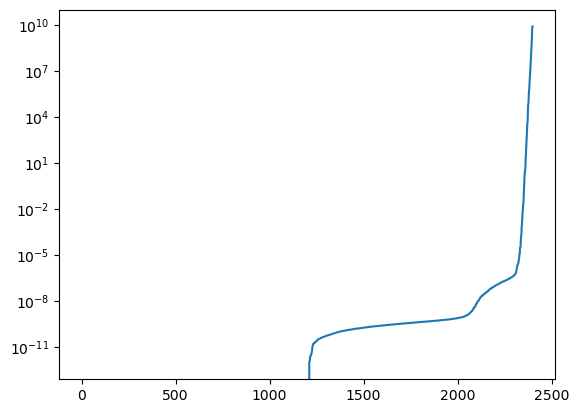

In [50]:
plt.plot(eigenvals)
plt.yscale('log')

In [51]:
gamma=100

In [52]:
ybs=jax.scipy.linalg.solve(K_mat+gamma*np.eye(K_mat.shape[0]),graph_discovery.X,assume_a='pos')
ybs

Array([[-5.78101144e-07,  8.80014981e-07,  8.94169730e-07, ...,
         3.05183943e-06,  5.16263263e-06, -9.11664929e-06],
       [ 6.18877223e-07, -1.68293120e-07, -3.99628734e-07, ...,
         1.24201201e-06, -1.06070649e-05,  8.86950054e-06],
       [-1.18352096e-05,  1.27228705e-05,  1.35884878e-05, ...,
         2.50991361e-07,  2.86315940e-07,  8.11592342e-08],
       ...,
       [ 3.06000446e-07,  1.89114946e-07,  2.16862202e-07, ...,
        -9.56808109e-07, -1.12027309e-05, -7.92476033e-06],
       [-2.32919541e-06,  1.34364960e-06,  1.44187080e-06, ...,
         6.60180017e-08,  6.02319565e-08,  3.42231216e-08],
       [ 3.36394277e-06, -1.58712550e-06, -1.69893316e-06, ...,
        -1.39201556e-07, -1.20931946e-07, -5.76690603e-08]],      dtype=float64)

In [53]:
indexes_treated=np.array([graph_discovery.name_to_index[name] for name in treated_and_non_zero])
ybs=ybs[:,indexes_treated]
ybs.shape

(2400, 1122)

In [54]:
df_test[treated_and_non_zero].values.shape

(2605, 1122)

In [55]:
graph_discovery.X.shape

(2400, 2244)

In [56]:
normalized_test_values=(df_test.values- graph_discovery.mean_x) / graph_discovery.std_x

K_pred=graph_discovery.kernels[0](normalized_test_values,graph_discovery.X,active_mode)

In [57]:
pred_no_pruning=K_pred@ybs
pred_no_pruning=(pred_no_pruning*graph_discovery.std_x[:,indexes_treated])+graph_discovery.mean_x[:,indexes_treated]

In [58]:
pred

Array([[-6.75312446e-02, -6.37063159e-02,  1.25284641e-01, ...,
         5.99644892e-07,  2.70549895e-11,  3.82168976e-10],
       [-1.24850458e+01,  4.34511268e-01, -3.10701176e-01, ...,
         3.38009201e-05, -2.68526033e-13,  1.53154535e-08],
       [-4.02883025e+00, -3.41830098e+00, -3.44105969e+00, ...,
         2.20136434e-05, -6.44308321e-12,  2.39523013e-10],
       ...,
       [-9.36537207e-03, -1.83378336e+02, -1.75258753e+02, ...,
        -6.93324626e+01,  2.47859588e-04, -2.07729094e-02],
       [-9.33453927e-03, -1.82555844e+02, -1.74503158e+02, ...,
        -6.93888205e+01,  2.54389829e-04, -2.06684877e-02],
       [-6.71828767e-02, -4.22062947e-02,  1.56528337e-01, ...,
         5.96030716e-07,  2.71429879e-11,  3.63562981e-10]],      dtype=float64)

In [59]:
pred_no_pruning

Array([[-1.77291516e+03, -1.95142468e+04, -1.95138476e+04, ...,
         3.47677679e-03,  6.77723508e-08,  4.07964951e-07],
       [ 1.60507058e+03,  1.74207058e+04,  1.74202455e+04, ...,
        -2.85711425e-03, -4.70916879e-08, -2.25784079e-07],
       [ 9.63859052e+02,  1.08852261e+04,  1.08850428e+04, ...,
        -1.49476197e-03, -3.24239511e-08, -1.69686669e-07],
       ...,
       [-7.22562533e+00, -2.29518288e+02, -2.22456175e+02, ...,
        -6.93390041e+01,  2.49297429e-04, -2.07583245e-02],
       [-7.30025002e+00, -2.29763945e+02, -2.22839934e+02, ...,
        -6.93951884e+01,  2.55862938e-04, -2.06532851e-02],
       [-1.77291027e+03, -1.95141593e+04, -1.95137601e+04, ...,
         3.47714756e-03,  6.77610151e-08,  4.07826794e-07]],      dtype=float64)

In [60]:
diffs_no_pruning=(df_test[treated_and_non_zero].values-pred_no_pruning)

In [61]:
errors= jax.numpy.median((diffs_no_pruning)**2,axis=0)/std**2

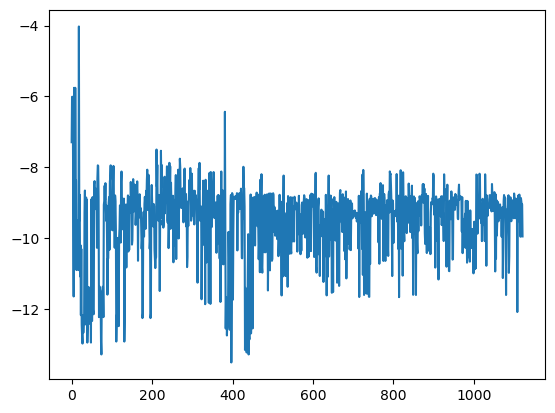

In [62]:
plt.plot(np.log10(errors))

In [63]:
np.mean(np.log10(errors)>0)

Array(0., dtype=float32)

In [64]:
int(10**np.mean(np.log10(errors))*100)

0

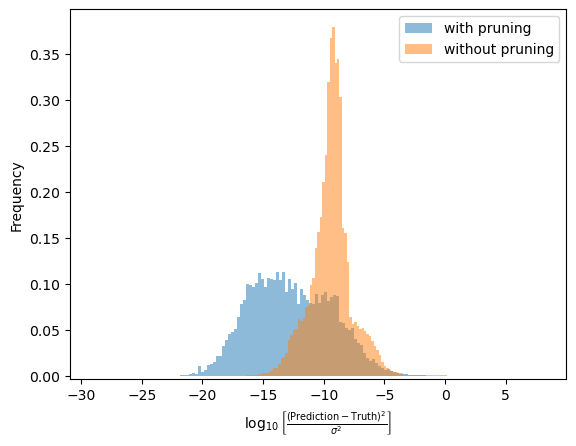

In [65]:
pruning_errors=((truth-pred)**2/std**2).flatten()
no_pruning_errors=((diffs_no_pruning)**2/std**2).flatten()

plt.hist(np.log10(pruning_errors),bins=150,alpha=0.5,label='with pruning',density=True)
plt.hist(np.log10(no_pruning_errors),bins=150,alpha=0.5,label='without pruning',density=True)

plt.xlabel('$\\log_{10}\\left[\\frac{(\\text{Prediction}-\\text{Truth})^2}{\\sigma^2}\\right]$')
plt.ylabel('Frequency')
plt.ylim(bottom=-0.003)
plt.legend()
plt.show()



In [66]:
np.sum(pruning_errors>no_pruning_errors)

Array(486210, dtype=int64)

In [67]:
pruning_errors.shape[0]

2922810

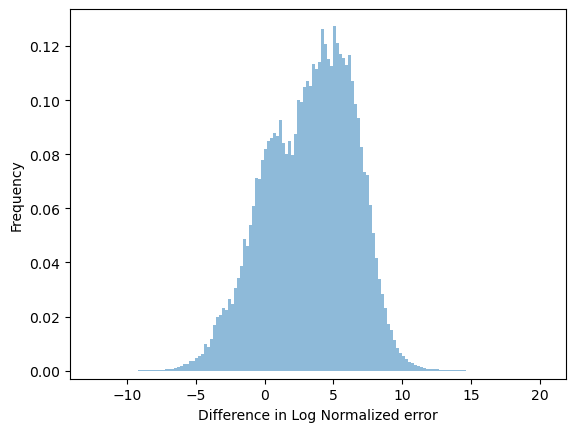

In [68]:
pruning_errors=((truth-pred)**2/std**2).flatten()
no_pruning_errors=((diffs_no_pruning)**2/std**2).flatten()

plt.hist(np.log10(no_pruning_errors)-np.log10(pruning_errors),bins=150,alpha=0.5,label='with pruning',density=True)


plt.xlabel('Difference in Log Normalized error')
plt.ylabel('Frequency')
plt.ylim(bottom=-0.003)
#plt.legend()
plt.show()

In [69]:
pruning_errors=((truth-pred)**2/std**2).flatten()


In [70]:
mode_chooser= CHD.decision.ThresholdModeChooser(threshold=0.025)

In [71]:
noises={}
noises_list=[]
for node in graph_discovery.G.nodes:
    if 'partial' not in node:
        continue
    node2=node.replace('/','\\')
    noise_record=np.load(f'./results_all_original_BCR/noise_evolution_{node2}.npy')
    index=mode_chooser(None,noise_record,None)
    noises[node]=float(noise_record[index])
    noises_list.append(float(noise_record[index]))
noises_list=np.array(noises_list)
noises

{'$/partial_t S0$': 0.006786603397552611,
 '$/partial_t S1$': 0.024978049436210927,
 '$/partial_t S2$': 0.024902398476773863,
 '$/partial_t S3$': 0.021797501942746933,
 '$/partial_t S4$': 0.011874573944727611,
 '$/partial_t S5$': 0.020756293461036607,
 '$/partial_t S6$': 0.023330939108761644,
 '$/partial_t S7$': 0.07453781218534358,
 '$/partial_t S8$': 0.05673985744317276,
 '$/partial_t S9$': 0.0233540647445509,
 '$/partial_t S10$': 0.024871962855564294,
 '$/partial_t S11$': 0.024935073116796123,
 '$/partial_t S12$': 0.03599346348483048,
 '$/partial_t S13$': 0.1328786033482207,
 '$/partial_t S14$': 0.015413674137049997,
 '$/partial_t S15$': 0.024951909249937353,
 '$/partial_t S16$': 0.022801087192093596,
 '$/partial_t S17$': 0.024859496863467893,
 '$/partial_t S18$': 0.0253317518683629,
 '$/partial_t S19$': 0.11960274484406115,
 '$/partial_t S20$': 0.022893973228286773,
 '$/partial_t S21$': 0.024785966946176144,
 '$/partial_t S22$': 0.02476103686784372,
 '$/partial_t S23$': 0.014651223

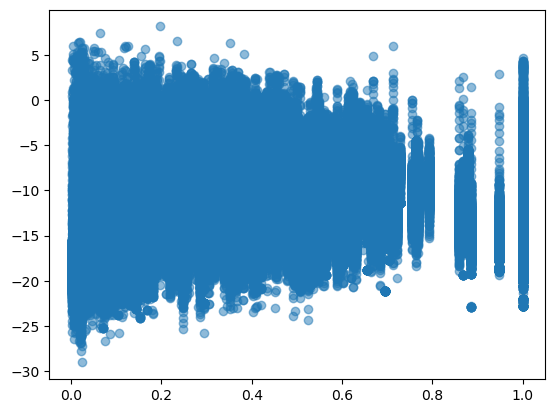

In [103]:
pruning_errors=((truth-pred)**2/std**2)
noises=np.array(noises_list)[None,:]*np.ones_like(pruning_errors)
plt.scatter(noises.flatten(),np.log10(pruning_errors.flatten()),alpha=0.5)

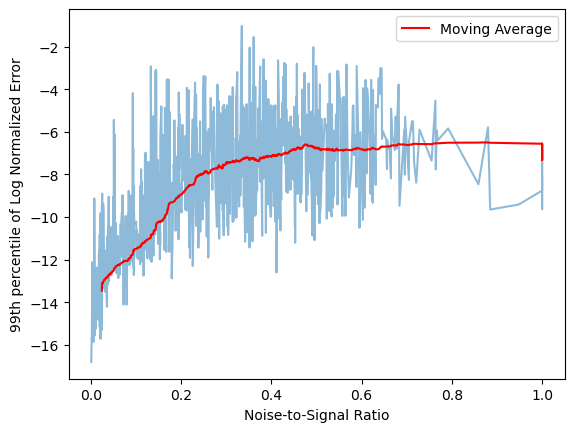

In [73]:
indexes=np.argsort(noises_list)
data=np.quantile(np.log10(pruning_errors),0.99,axis=0)[indexes]
window_width = 150
cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
plt.plot(noises_list[indexes],data,alpha=0.5)
plt.plot(noises_list[indexes][window_width-1:],ma_vec,color='red',label='Moving Average')
plt.ylabel('99th percentile of Log Normalized Error')
plt.xlabel('Noise-to-Signal Ratio')
plt.legend()

10it [00:00, 80.41it/s]


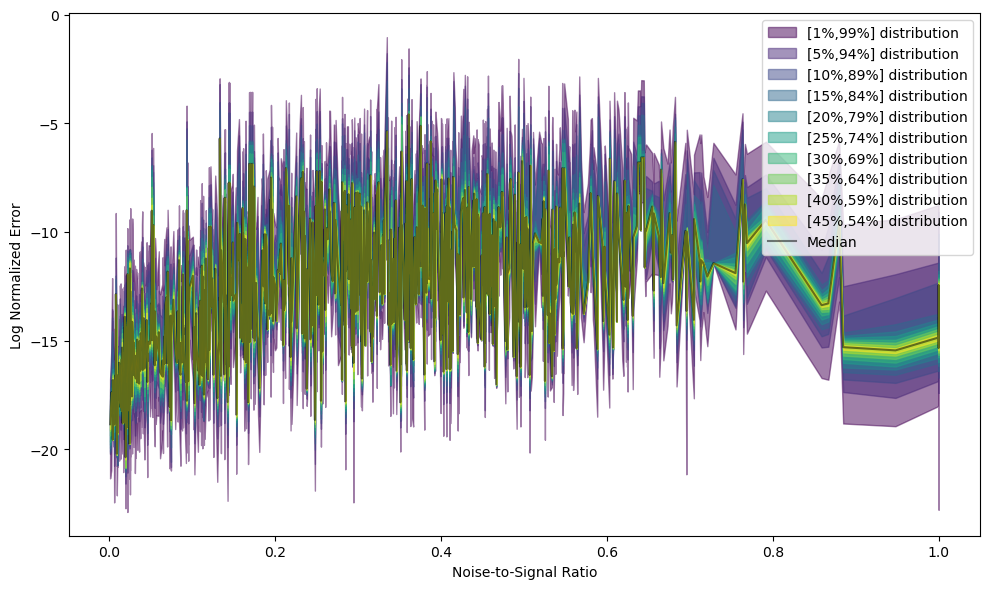

In [96]:


fig, ax = plt.subplots(figsize=(10, 6))

# Add the bands to the axes
n_bars=10
quantiles=np.linspace(0.01,0.5,n_bars,endpoint=False)
colors = plt.cm.viridis(np.linspace(0, 1, n_bars))
sorted=np.sort(np.log10(pruning_errors),axis=0)
for t_low,color in tqdm(zip(quantiles,colors)):
    t_high_opp=1-t_low
    data_low=sorted[int(t_low*pruning_errors.shape[0])]
    data_high=sorted[int(t_high_opp*pruning_errors.shape[0])]
    ax.fill_between(noises_list[indexes],data_low[indexes],data_high[indexes],alpha=0.5,color=color,label=f'[{int(t_low*100)}%,{int(t_high_opp*100)}%] interval')
    '''data_low_opp=np.quantile(np.log10(pruning_errors),t_low_opp,axis=0)
    data_high_opp=np.quantile(np.log10(pruning_errors),t_high_opp,axis=0)
    ax.fill_between(noises_list[indexes],data_low_opp[indexes],data_high_opp[indexes],alpha=0.5,color=color)'''

# Plot the median as line
ax.plot(noises_list[indexes], np.median(np.log10(pruning_errors),axis=0)[indexes], '-', color="k", label="Median",alpha=0.5)

# Add title, legend and plot
ax.set_xlabel("Noise-to-Signal Ratio")
ax.set_ylabel("Log Normalized Error")
ax.legend()
#ax.legend([f"{n}% distribution" for n in [99, 90, 50]] + ["Median"], loc="upper left")
fig.tight_layout()

10it [00:00, 44.76it/s]


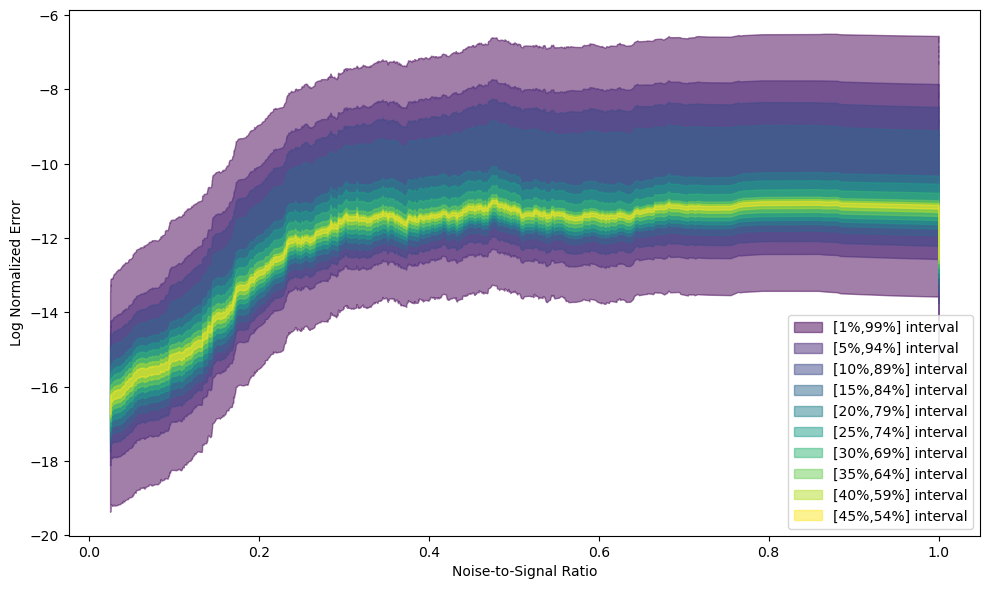

In [110]:
fig, ax = plt.subplots(figsize=(10, 6))

# Add the bands to the axes
n_bars=10
quantiles=np.linspace(0.01,0.5,n_bars,endpoint=False)
colors = plt.cm.viridis(np.linspace(0, 1, n_bars))
sorted=np.sort(np.log10(pruning_errors),axis=0)
for t_low,color in tqdm(zip(quantiles,colors)):
    t_high_opp=1-t_low
    data_low=sorted[int(t_low*pruning_errors.shape[0])][indexes]
    data_high=sorted[int(t_high_opp*pruning_errors.shape[0])][indexes]
    window_width = 150
    cumsum_vec_low = np.cumsum(np.insert(data_low, 0, 0)) 
    ma_vec_low = (cumsum_vec_low[window_width:] - cumsum_vec_low[:-window_width]) / window_width
    cumsum_vec_high = np.cumsum(np.insert(data_high, 0, 0))
    ma_vec_high = (cumsum_vec_high[window_width:] - cumsum_vec_high[:-window_width]) / window_width
    '''ma_vec_low=np.convolve(np.pad(data_low,(window_width,window_width),mode='edge'), np.ones(window_width)/window_width, mode='same')[window_width:-window_width]
    ma_vec_high=np.convolve(np.pad(data_high,(window_width,window_width),mode='edge'), np.ones(window_width)/window_width, mode='same')[window_width:-window_width]'''
    ax.fill_between(noises_list[indexes][window_width-1:],ma_vec_low,ma_vec_high,alpha=0.5,color=color,label=f'[{int(t_low*100)}%,{int(t_high_opp*100)}%] interval')
    '''data_low_opp=np.quantile(np.log10(pruning_errors),t_low_opp,axis=0)
    data_high_opp=np.quantile(np.log10(pruning_errors),t_high_opp,axis=0)
    ax.fill_between(noises_list[indexes],data_low_opp[indexes],data_high_opp[indexes],alpha=0.5,color=color)'''

# Plot the median as line

# Add title, legend and plot
ax.set_xlabel("Noise-to-Signal Ratio")
ax.set_ylabel("Log Normalized Error")
ax.legend(loc='lower right')
#ax.legend([f"{n}% distribution" for n in [99, 90, 50]] + ["Median"], loc="upper left")
fig.tight_layout()

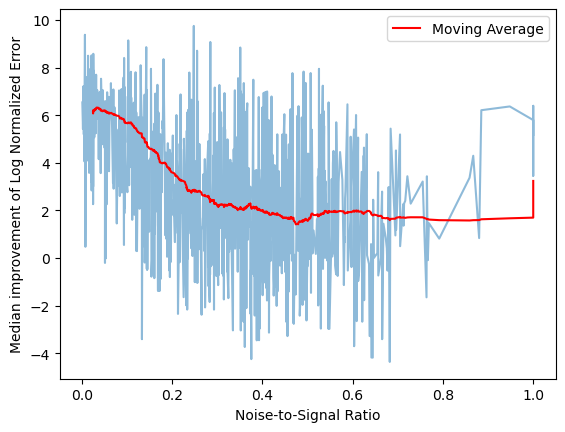

In [136]:
indexes=np.argsort(noises_list)
no_pruning_errors=((diffs_no_pruning)**2/std**2)
improvement=np.log10(no_pruning_errors)-np.log10(pruning_errors)
data=np.median(improvement,axis=0)[indexes]
window_width = 150
cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
plt.plot(noises_list[indexes],data,alpha=0.5)
plt.plot(noises_list[indexes][window_width-1:],ma_vec,color='red',label='Moving Average')
plt.ylabel('Median improvement of Log Normalized Error')
plt.xlabel('Noise-to-Signal Ratio')
plt.legend()

In [104]:
no_pruning_errors=((diffs_no_pruning)**2/std**2)

10it [00:00, 44.55it/s]


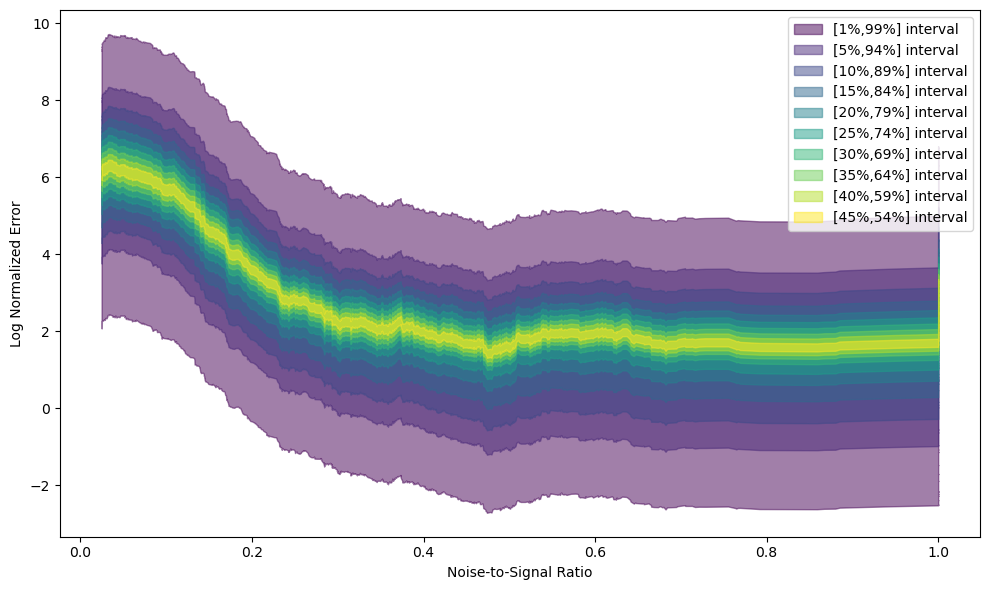

In [109]:
fig, ax = plt.subplots(figsize=(10, 6))

# Add the bands to the axes
n_bars=10
quantiles=np.linspace(0.01,0.5,n_bars,endpoint=False)
colors = plt.cm.viridis(np.linspace(0, 1, n_bars))
sorted=np.sort(np.log10(no_pruning_errors)-np.log10(pruning_errors),axis=0)
for t_low,color in tqdm(zip(quantiles,colors)):
    t_high_opp=1-t_low
    data_low=sorted[int(t_low*pruning_errors.shape[0])][indexes]
    data_high=sorted[int(t_high_opp*pruning_errors.shape[0])][indexes]
    window_width = 150
    cumsum_vec_low = np.cumsum(np.insert(data_low, 0, 0)) 
    ma_vec_low = (cumsum_vec_low[window_width:] - cumsum_vec_low[:-window_width]) / window_width
    cumsum_vec_high = np.cumsum(np.insert(data_high, 0, 0))
    ma_vec_high = (cumsum_vec_high[window_width:] - cumsum_vec_high[:-window_width]) / window_width
    #ma_vec_low=np.convolve(np.pad(data_low,(window_width,window_width),mode='edge'), np.ones(window_width)/window_width, mode='same')[window_width:-window_width]
    #ma_vec_high=np.convolve(np.pad(data_high,(window_width,window_width),mode='edge'), np.ones(window_width)/window_width, mode='same')[window_width:-window_width]
    ax.fill_between(noises_list[indexes][window_width-1:],ma_vec_low,ma_vec_high,alpha=0.5,color=color,label=f'[{int(t_low*100)}%,{int(t_high_opp*100)}%] interval')
    '''data_low_opp=np.quantile(np.log10(pruning_errors),t_low_opp,axis=0)
    data_high_opp=np.quantile(np.log10(pruning_errors),t_high_opp,axis=0)
    ax.fill_between(noises_list[indexes],data_low_opp[indexes],data_high_opp[indexes],alpha=0.5,color=color)'''

# Plot the median as line

# Add title, legend and plot
ax.set_xlabel("Noise-to-Signal Ratio")
ax.set_ylabel("Log Normalized Error")
ax.legend(loc='upper right')
#ax.legend([f"{n}% distribution" for n in [99, 90, 50]] + ["Median"], loc="upper left")
fig.tight_layout()